# Baseline A/B Comparison: Communication Channel Effect

## Objective

This section evaluates whether there is a statistically significant difference in conversion rates between communicadtion channels (cellular vs telephone). This is a descriptive comparison and does not account for potential confounding factors. Regression adjustment follows in the next step.

Although the dataset contains historical campaign logs, we treat it as a sample realisation of customer outcomes for group-level performance estimation.

## 1. Setup & Load Data
Load required libraries and import the dataset used for analsis.

In [63]:
# Import Libraries
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest, proportion_confint, confint_proportions_2indep
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('../data/preprocessed-bank-data.csv')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

## 2. Define Treatment and Control Groups

- Treatment: `cellular`
- Control: `telephone`

Create a binary treatment flag (`treated = 1` for cellular).

In [10]:
df_ab = df[df['contact'] .isin(['cellular', 'telephone'])].copy()
# treatment flag: treated = 1 if contact == cellular
df_ab['treated'] = (df_ab['contact'] == 'cellular').astype(int)

## 3. Baseline KPI Summary (Conversion Rate)

Compute conversion rate by group:

- Sample size (n)
- Number of conversions
- Conversion rate (mean of `y`)

Since the target varialbe `y` is binary (1 = subscribed, 0 = not subscribed), the conversion rate is computed as the sample mean within each group. This corresponds to the standard proportion estimator for a binary outcome.

### Sample Size Identification

In [11]:
df_ab['contact'].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [15]:
df_ab['contact'].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [22]:
total = df_ab['contact'].count()

prop_cell = np.round((26144/total)*100,2)
prop_tel =  np.round((15044/total)*100,2)

print(f"Sample size ratio of Cellular:{prop_cell}%")
print(f"Sample size ratio of Telephone: {prop_tel}%")

Sample size ratio of Cellular:63.47%
Sample size ratio of Telephone: 36.53%


The sample allocation is moderately unbalanced (63% cellular vs 37% telephone), but both groups have sufficiently large sample sizes. Therefore, statistical comparison remains valid. However, allocation is not randomised, and channel assignment may correlate with customer characteristics, requiring regression adjustment in subsequent analysis.

### Create KPI Summary

In [21]:
kpi_summary = (df_ab.groupby('contact')['y']
               .agg(n= 'count',
                    conversions = 'sum',
                    conversion_rate = 'mean'))


kpi_summary = kpi_summary.loc[['telephone', 'cellular']]

kpi_summary

,n,conversions,conversion_rate
contact,,,
telephone,15044,787,0.052313
cellular,26144,3853,0.147376


The cellular channel shows a substantially higher conversion rate (14.74%) compared to telephone (5.23%), representing a remarkable performance gap. Although sample sizes differ (26,144 vs 15,044), both groups are sufficiently large to support statistical comparison.

This initial comparision is descriptive and does not yet account for potential confounding factors such as customer characteristics or campaign timing.

### Calculate Absolute Lift

Beyond statistical significance, we quantify the magnitude of the performance difference using **absolute lift**, defined as the difference in conversion rates between treatment and control groups:

$$\text{Absolute Lift} = \hat{p}_{cellular} - \hat{p}_{telephone}$$

This measures the percentage-point improvement in conversion and provides practical context before conducting hypothesis testing.

In [30]:
p_cell = kpi_summary.loc['cellular','conversion_rate'].round(4) * 100
p_tel = kpi_summary.loc['telephone', 'conversion_rate'].round(4) * 100

abs_lift = (p_cell - p_tel).round(2)

print(f"Absolute Lift: {abs_lift} percentage points")

Absolute Lift: 9.51 percentage points


Cellular contact yields an additional **9.51** conversions per 100 customers contacted compared to telephone.

## 4. Hypothesis Test (Two-Proportion z-test)

Test whether conversion rates differ between treatment and control groups.

- $H0: p_{cellular} = p_{telephone}$
- $H1: p_{cellular} \neq p_{telephone}$ (two-sided)

In [58]:
# n = Sample Size
n1 = kpi_summary.loc['cellular', 'n']
n2 = kpi_summary.loc['telephone', 'n']

# c1 = number of conversions of cellular
c1 = kpi_summary.loc['cellular', 'conversions']
# c2 = number of conversions of telephone
c2 = kpi_summary.loc['telephone', 'conversions']

count = [c1, c2]
nobs = [n1, n2]

z_stat, p_value = proportions_ztest(count, nobs)

display_pval = f"p-value < 0.001" if p_value < 0.001 else f"p-value: {p_value: .3f}"

print(f"z-statistic: {z_stat:.3f}")
print(display_pval)

z-statistic: 29.381
p-value < 0.001


### Hypothesis Test Result

The two-proportion z-test (z = 29.38) indicates a statistically significant difference in conversion rates between the two channels (p-value < 0.001).

Specifically, the cellular channel demonstrates a materially higher conversion rate compared to telephone contact.

This suggests that communication channel selection has a meaningful impact on campaign performance at the baseline level.

While the statistical evidence is overwhelming, this comparison is observational and does not yet account for potential confounding factors. Further regression adjustment is required to assess causal impact.

## 5. Effect Size

Report practical significance alongside p-values:
- Absolute lift (percentage-point difference)
    - Cellular conversion: 14.74%
    - Telephone conversion: 5.23%
    - Absolute lift: +9.51 percentage points

Cellular contact yields and additional 9.51 conversions per 100 customers contacted compared to telephone.
- Relative lift
$$\text{Relative Lift} = \frac{p_{cellular} - p_{telephone}}{p_{telephone}}$$

In [60]:
# Calculate Relative lift
relative_lift = ((p_cell-p_tel)/p_tel).round(2)

print(f"Relative Lift: {relative_lift*100}%")

Relative Lift: 182.0%


Cellular achieves approximately a **182% higher conversion rate** relative to telephone.


While the statistical test confirms significance, effect size quantifies the magnitude of the difference.
The cellular channel achieves a conversion rate of 14.74% compared to 5.23% for telephone, resulting in an absolute lift of +9.51%p. This implies approximately 9.5 additional conversions per 100 customers contacted.

In relative terms, this corresponds to a 182% higher conversion rate compared to the telephone channel, indicating a substantial proportional advantage within this observational sample.

## 6. Confidence Intervals (CI)

Compute 95% confidence intervals for conversion rates.
This helps quantify uncertainty beyond statistical significance.

$$\text{Confidence Intervals} = \hat{p} \pm 1.96\sqrt{\frac{\hat{p}(1-\hat{p})}{n}} $$

### Confidence Intervals of each group (Cellular and Telephone)

In [66]:
# Use c1,2 and n1,2 from KPI Summary table
ci_cell = proportion_confint(c1, n1, alpha = .05, method = 'normal')
ci_tel = proportion_confint(c2, n2, alpha = .05, method='normal')

print("Cellular CI:", ci_cell)
print("Telephone CI:", ci_tel)

Cellular CI: (0.14307918016769616, 0.15167296181516798)
Telephone CI: (0.04875522603097157, 0.05587120311021429)


According to the calculation, the true conversion rate for cellular likely lies between 14.31% and 15.17%. The true conversion rate for telephone lies between 4.88% and 5.59%.

### Confidence Intervals of Difference

$$(p_1 - p_2) \pm 1.96 \cdot SE$$


In [64]:
ci_diff = confint_proportions_2indep(c1, n1, c2, n2, method= 'wald')

print("CI for difference:", ci_diff)

CI for difference: (np.float64(0.08948409731157633), np.float64(0.10064161553010195))


The 95% confidence interval for the difference in conversion rates ranges from 8.95 to 10.07 percentage points. Since the interval does not cross zero, the difference remains statistically significant. Moreover, the relatively narrow interval indicates that the estimated uplift is precise and unlikely to be driven by sampling variability.

## 7. Visualisation

Visualise baseline conversion rate by channel (one chart only).
Include error bars if confidence intervals are available.

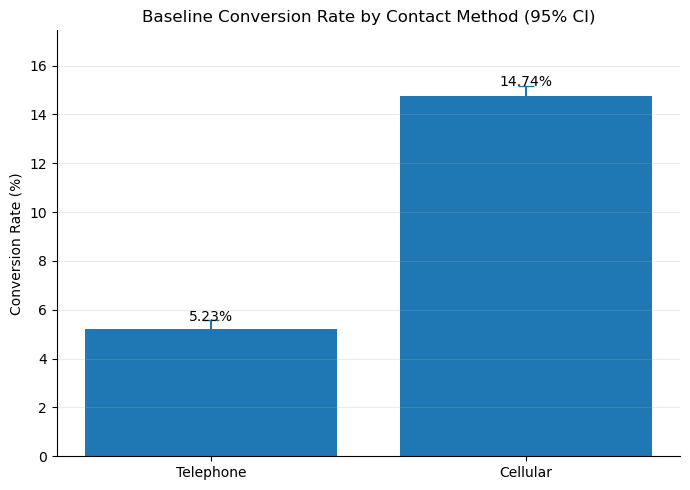

In [68]:
def plot_conversion_rate_with_ci(kpi_summary, ci_cell, ci_tel,
                                 order = ('telephone', 'cellular'),
                                 title = 'Baseline Conversion Rate by Contact Method (95% CI)'):
    """
    kpi_summary: index = contact, columns include 'conversion_rate'
    ci_cell / ci_tel: tuple (lower, upper) in proportion units (0-1)
    """

    ci_map = {
        'cellular': ci_cell,
        'telephone': ci_tel
    }


    dfp = kpi_summary.loc[list(order)].copy()

    rates_pct = (dfp['conversion_rate'].astype(float).values) * 100
    lowers = np.array([ci_map[m][0] for m in order], dtype=float) * 100
    uppers = np.array([ci_map[m][1] for m in order], dtype=float) * 100
    yerr = np.vstack([rates_pct - lowers, uppers - rates_pct])

    x = np.arange(len(order))
    fig, ax = plt.subplots(figsize = (7, 5))

    ax.bar(x, rates_pct)
    ax.errorbar(x, rates_pct, yerr=yerr, fmt = 'none', capsize=6, linewidth=1.5)

    ax.set_title(title,  fontsize = 12)
    ax.set_ylabel("Conversion Rate (%)")
    ax.set_xticks(x)
    ax.set_xticklabels([m.title() for m in order])

    # value labels
    for i, v in enumerate(rates_pct):
        ax.text(i, v + max(0.2, 0.02*v), f"{v:.2f}%", ha = "center",
                va="bottom")
    # y-limit
    ax.set_ylim(0, max(1, max(uppers) * 1.15))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha = .25)

    plt.tight_layout()
    return fig, ax

plot_conversion_rate_with_ci(kpi_summary, ci_cell, ci_tel)
plt.show()

- We visualise baseline conversion rates by channel with 95% confidence intervals to summarise both the point estimates and uncertainity.
- This provides a business-ready view of the observed performance gap, before applying regression adjustment for confounding.

## 8. Interpretation and Limitation

While the difference in baseline conversion rates is statistically significant, this analysis remains descriptive. Because contact method was not randomly assigned, the observed uplift may be influenced by selection bias or confounding factors. Therefore, regression adjustment is required to assess robustness.

## 9. Summary

Cellular contact demonstrates a substantially higher baseline conversion rate (14.74%) compared to telephone (5.23%), representing an absolute uplift of 9.51 percentage points (182% relative increase).

The difference is statistically significant (p < 0.001), and confidence intervals indicates a stable and precise estimate.

However, this comparison is descriptive and does not imply casual impact. Further regression analysis is required to control for customer characteristics and potential confounding factors before making strategic channel decision.